In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from itertools import cycle
from torchinfo import summary
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torchvision import datasets, transforms
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
input_path = Path('/kaggle/input')
for directory in input_path.rglob('*'):
    if directory.is_dir():
        print(directory)

/kaggle/input/iqothnccd-lung-cancer-dataset
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases


In [ ]:
batch_size = 32
input_shape = (224, 224, 3) 
target_size = (224, 224)    
seed = 42

In [ ]:
data_dir = "/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

transform_no_norm = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])

dataset_no_norm = datasets.ImageFolder(root=data_dir, transform=transform_no_norm)

loader = DataLoader(dataset_no_norm, batch_size=batch_size, shuffle=False, num_workers=2)

mean = 0.0
std = 0.0
nb_samples = 0

for data, _ in loader:
    batch_samples = data.size(0) 
    data = data.view(batch_samples, data.size(1), -1) 
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Calculated mean:", mean)
print("Calculated std:", std)

Calculated mean: tensor([0.4098, 0.4098, 0.4098])
Calculated std: tensor([0.2928, 0.2928, 0.2928])


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

generator = torch.Generator().manual_seed(seed)
train_dataset, valid_dataset, test_dataset = random_split(
    full_dataset, [train_size, valid_size, test_size], generator=generator
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
train_targets = np.array([full_dataset.targets[i] for i in train_dataset.indices])
valid_targets = np.array([full_dataset.targets[i] for i in valid_dataset.indices])
test_targets  = np.array([full_dataset.targets[i] for i in test_dataset.indices]) 

classes = full_dataset.classes
num_classes = len(classes)

train_counts = np.bincount(train_targets, minlength=num_classes)
valid_counts = np.bincount(valid_targets, minlength=num_classes)
test_counts  = np.bincount(test_targets, minlength=num_classes)

import pandas as pd

df = pd.DataFrame({
    'Class': classes,
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})
print(df)

             Class  Train  Validation  Test
0     Bengin cases     84          19    17
1  Malignant cases    389          86    86
2     Normal cases    294          59    63


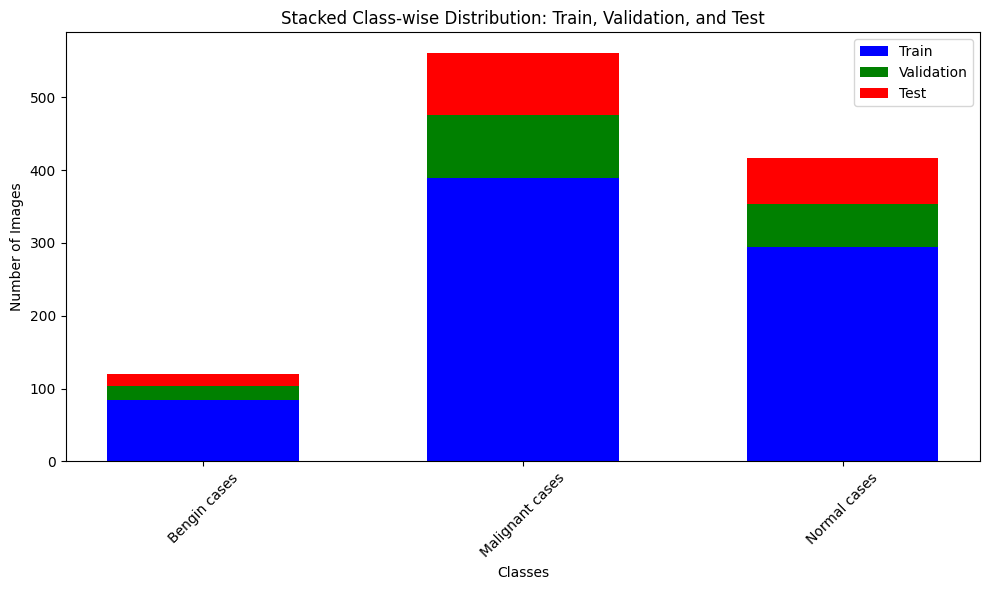

In [ ]:
x = np.arange(num_classes) 
bar_width = 0.6

plt.figure(figsize=(10, 6))
plt.bar(x, train_counts, bar_width, color='blue', label='Train')
plt.bar(x, valid_counts, bar_width, bottom=train_counts, color='green', label='Validation')
plt.bar(x, test_counts, bar_width, bottom=train_counts + valid_counts, color='red', label='Test')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(x, classes, rotation=45)
plt.title('Stacked Class-wise Distribution: Train, Validation, and Test')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

num_classes = 10 

model.heads = nn.Sequential(
    nn.Linear(model.heads[0].in_features, num_classes)
)

model = model.to(device)
summary(model, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 65.1MB/s] 


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 10]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()

    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    if cm.shape[0] == 2 and cm.shape[1] == 2:
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        specificity = None
        sensitivity = None

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []
    unique_classes = np.unique(y_true_numpy)
    if len(unique_classes) > 1:
        for class_idx in range(num_classes):
            class_y_true = (y_true_numpy == class_idx).astype(np.float32)
            class_y_pred = y_pred[:, class_idx].cpu().numpy()
            if np.all(class_y_true == 0) or np.all(class_y_true == 1):
                continue
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        auc_avg = np.nanmean(auc_scores) if auc_scores else None
    else:
        auc_avg = None

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25 
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device) 
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    
    training_metrics_line = "Training Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_value is None:
            training_metrics_line += f"{metric_name}: N/A, "
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(valid_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(valid_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Validation Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_value is None:
            validation_metrics_line += f"{metric_name}: N/A, "
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Training Metrics - loss: 0.8852, accuracy: 0.7106, precision: 0.6747, recall: 0.7106, f1_score: 0.6911, specificity: N/A, sensitivity: N/A, mcc: 0.4949, auc: 0.6761, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


Validation Metrics - loss: 0.5312, accuracy: 0.8598, precision: 0.7790, recall: 0.8598, f1_score: 0.8123, specificity: N/A, sensitivity: N/A, mcc: 0.7707, auc: 0.8458, 


Training Model - Epoch [2/25]: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]


Training Metrics - loss: 0.3827, accuracy: 0.8605, precision: 0.8606, recall: 0.8605, f1_score: 0.8202, specificity: N/A, sensitivity: N/A, mcc: 0.7660, auc: 0.9252, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


Validation Metrics - loss: 0.3653, accuracy: 0.8841, precision: 0.7965, recall: 0.8841, f1_score: 0.8343, specificity: N/A, sensitivity: N/A, mcc: 0.8129, auc: 0.9072, 


Training Model - Epoch [3/25]: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]


Training Metrics - loss: 0.2547, accuracy: 0.9022, precision: 0.9018, recall: 0.9022, f1_score: 0.8847, specificity: N/A, sensitivity: N/A, mcc: 0.8348, auc: 0.9643, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


Validation Metrics - loss: 0.2960, accuracy: 0.8902, precision: 0.8798, recall: 0.8902, f1_score: 0.8569, specificity: N/A, sensitivity: N/A, mcc: 0.8189, auc: 0.9156, 


Training Model - Epoch [4/25]: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


Training Metrics - loss: 0.1509, accuracy: 0.9635, precision: 0.9648, recall: 0.9635, f1_score: 0.9614, specificity: N/A, sensitivity: N/A, mcc: 0.9381, auc: 0.9898, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


Validation Metrics - loss: 0.2034, accuracy: 0.9207, precision: 0.9238, recall: 0.9207, f1_score: 0.9080, specificity: N/A, sensitivity: N/A, mcc: 0.8674, auc: 0.9542, 


Training Model - Epoch [5/25]: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


Training Metrics - loss: 0.0803, accuracy: 0.9778, precision: 0.9779, recall: 0.9778, f1_score: 0.9773, specificity: N/A, sensitivity: N/A, mcc: 0.9621, auc: 0.9963, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


Validation Metrics - loss: 0.1966, accuracy: 0.9207, precision: 0.9222, recall: 0.9207, f1_score: 0.9214, specificity: N/A, sensitivity: N/A, mcc: 0.8642, auc: 0.9591, 


Training Model - Epoch [6/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0343, accuracy: 0.9948, precision: 0.9948, recall: 0.9948, f1_score: 0.9948, specificity: N/A, sensitivity: N/A, mcc: 0.9911, auc: 0.9995, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


Validation Metrics - loss: 0.1082, accuracy: 0.9451, precision: 0.9441, recall: 0.9451, f1_score: 0.9421, specificity: N/A, sensitivity: N/A, mcc: 0.9061, auc: 0.9891, 


Training Model - Epoch [7/25]: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Training Metrics - loss: 0.0137, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


Validation Metrics - loss: 0.1000, accuracy: 0.9451, precision: 0.9441, recall: 0.9451, f1_score: 0.9421, specificity: N/A, sensitivity: N/A, mcc: 0.9061, auc: 0.9942, 


Training Model - Epoch [8/25]: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Training Metrics - loss: 0.0084, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation Metrics - loss: 0.1082, accuracy: 0.9390, precision: 0.9374, recall: 0.9390, f1_score: 0.9378, specificity: N/A, sensitivity: N/A, mcc: 0.8950, auc: 0.9931, 


Training Model - Epoch [9/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0061, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


Validation Metrics - loss: 0.1034, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9935, 


Training Model - Epoch [10/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0048, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Validation Metrics - loss: 0.1072, accuracy: 0.9390, precision: 0.9374, recall: 0.9390, f1_score: 0.9378, specificity: N/A, sensitivity: N/A, mcc: 0.8950, auc: 0.9933, 


Training Model - Epoch [11/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0040, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation Metrics - loss: 0.1091, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9940, 


Training Model - Epoch [12/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0034, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation Metrics - loss: 0.1147, accuracy: 0.9390, precision: 0.9374, recall: 0.9390, f1_score: 0.9378, specificity: N/A, sensitivity: N/A, mcc: 0.8950, auc: 0.9933, 


Training Model - Epoch [13/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0029, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


Validation Metrics - loss: 0.1152, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9938, 


Training Model - Epoch [14/25]: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Training Metrics - loss: 0.0026, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation Metrics - loss: 0.1188, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9939, 


Training Model - Epoch [15/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0023, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


Validation Metrics - loss: 0.1197, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9939, 


Training Model - Epoch [16/25]: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Training Metrics - loss: 0.0021, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]


Validation Metrics - loss: 0.1238, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9938, 


Training Model - Epoch [17/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0019, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


Validation Metrics - loss: 0.1276, accuracy: 0.9451, precision: 0.9443, recall: 0.9451, f1_score: 0.9446, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9935, 


Training Model - Epoch [18/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0017, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]


Validation Metrics - loss: 0.1268, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9939, 


Training Model - Epoch [19/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0016, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Validation Metrics - loss: 0.1297, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9941, 


Training Model - Epoch [20/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0015, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Validation Metrics - loss: 0.1297, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9942, 


Training Model - Epoch [21/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0014, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Validation Metrics - loss: 0.1317, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9942, 


Training Model - Epoch [22/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0013, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


Validation Metrics - loss: 0.1358, accuracy: 0.9451, precision: 0.9435, recall: 0.9451, f1_score: 0.9435, specificity: N/A, sensitivity: N/A, mcc: 0.9056, auc: 0.9942, 


Training Model - Epoch [23/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0012, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


Validation Metrics - loss: 0.1371, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9940, 


Training Model - Epoch [24/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0011, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


Validation Metrics - loss: 0.1362, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9941, 


Training Model - Epoch [25/25]: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


Training Metrics - loss: 0.0011, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

Validation Metrics - loss: 0.1380, accuracy: 0.9512, precision: 0.9501, recall: 0.9512, f1_score: 0.9503, specificity: N/A, sensitivity: N/A, mcc: 0.9160, auc: 0.9941, 
Total Training Time: 0:06:20.080707
Total Validation Time: 0:00:33.393195
Average Training Time per Epoch: 0:00:15.203228
Average Validation Time per Epoch: 0:00:01.335728


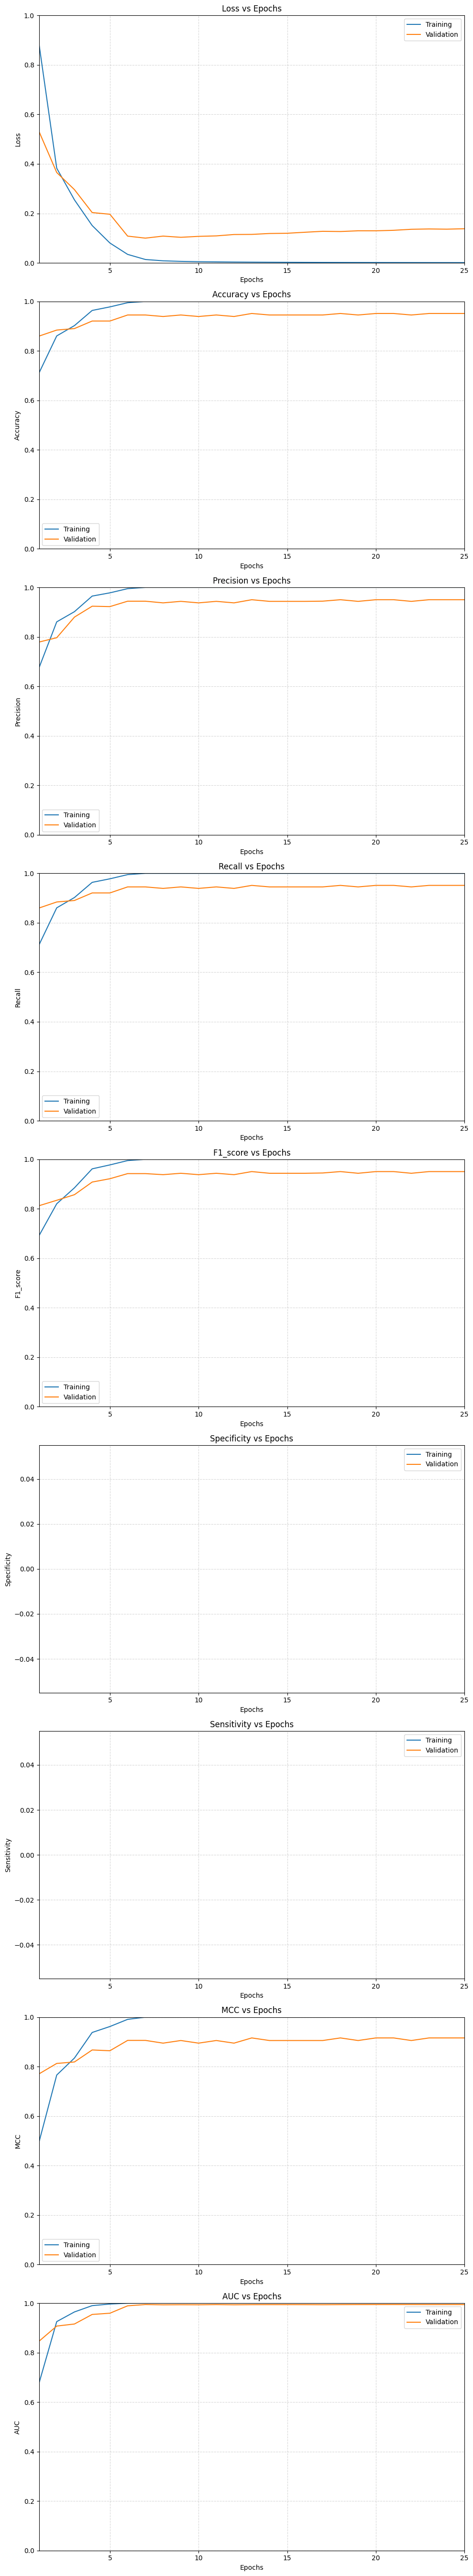

In [ ]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    
    if num_metrics == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    
    rng = range(1, num_epochs + 1)
    
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        
        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")
        
        valid_train = [m for m in train_metric if m is not None]
        valid_val = [m for m in val_metric if m is not None]
        
        if valid_train or valid_val:
            max_metric = max((max(valid_train) if valid_train else float('-inf')),
                             (max(valid_val) if valid_val else float('-inf')))
            min_metric = min((min(valid_train) if valid_train else float('inf')),
                             (min(valid_val) if valid_val else float('inf')))
            y_max = math.ceil(max_metric)
            if min_metric > 0 or max_metric > 1:
                ax.set_ylim(0, y_max)
            else:
                ax.set_ylim(min_metric, y_max)
        
        ax.grid(True, linestyle='--', alpha=0.5)
        if num_epochs > 1:
            ax.set_xlim(1, num_epochs)
    
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [14]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_value is None:
        testing_metrics_line += f"{metric_name}: N/A, "
    elif metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(testing_metrics_line)

Testing Model: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

Metrics - loss: 0.0574, accuracy: 0.9819, precision: 0.9817, recall: 0.9819, f1_score: 0.9817, specificity: N/A, sensitivity: N/A, mcc: 0.9687, auc: 0.9980


In [15]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                 precision    recall  f1-score   support

   Bengin cases     0.9375    0.8824    0.9091        17
Malignant cases     1.0000    1.0000    1.0000        86
   Normal cases     0.9688    0.9841    0.9764        63

       accuracy                         0.9819       166
      macro avg     0.9688    0.9555    0.9618       166
   weighted avg     0.9817    0.9819    0.9817       166

There were 3 errors in 166 tests for an accuracy of  98.19


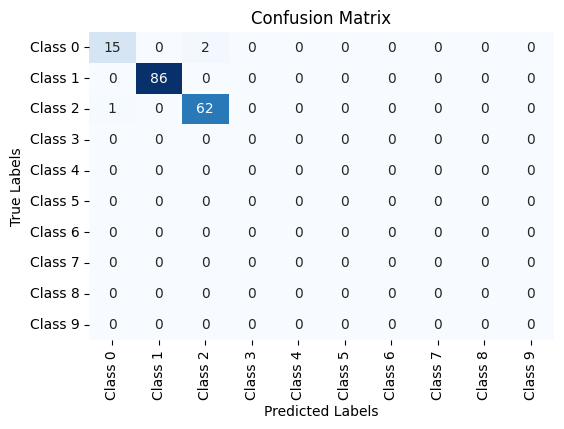

In [23]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
true_labels = []
predicted_probs = []

model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Processing test batches"):
        images = images.to(next(model.parameters()).device)
        outputs = model(images)  
        probabilities = torch.softmax(outputs, dim=1)
        
        predicted_probs.append(probabilities.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

predicted_probs = np.concatenate(predicted_probs, axis=0) 
true_labels = np.concatenate(true_labels, axis=0)        

if true_labels.ndim == 1:
    num_classes = predicted_probs.shape[1]
    true_labels_onehot = label_binarize(true_labels, classes=range(num_classes))
else:
    num_classes = true_labels.shape[1]
    true_labels_onehot = true_labels

try:
    if len(classes) != num_classes:
        classes = [f"Class {i}" for i in range(num_classes)]
except NameError:
    classes = [f"Class {i}" for i in range(num_classes)]

Processing test batches: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

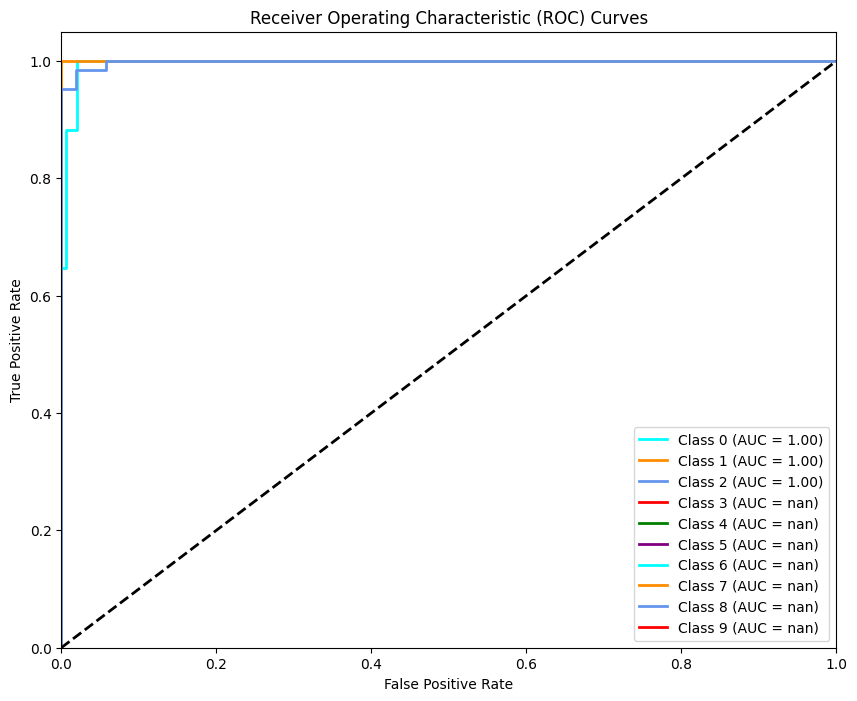

Saved ROC plot with only curves as 'roc_plot_no_labels.png'


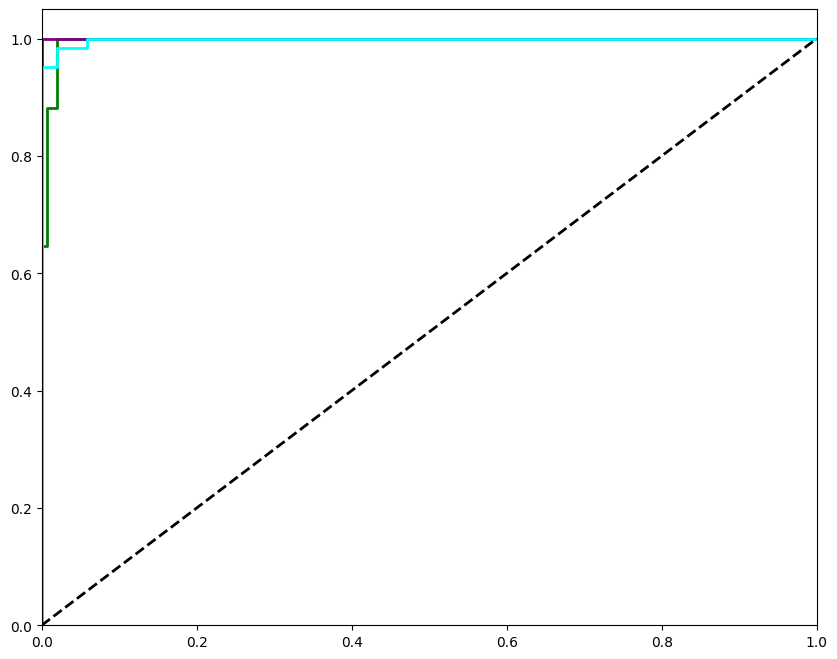

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2)
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.savefig("roc_plot_no_labels.png", bbox_inches='tight')
print("Saved ROC plot with only curves as 'roc_plot_no_labels.png'")
plt.show()

In [ ]:
excel_filename = "roc_data.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for i in range(num_classes):
        df = pd.DataFrame({
            'FPR': fpr[i],
            'TPR': tpr[i]
        })
        df['AUC'] = roc_auc[i] 
        sheet_name = classes[i][:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"ROC metrics saved to {excel_filename}")

ROC metrics saved to roc_data.xlsx
